## COMP 4437 WEEK 9 Assignment
---
The task in this assignment is a classifier for the CIFAR-10 dataset.  Dataset consists of 32x32 colour images in 10 classes. The classifier must predict class of it given its image. You are provided the codes to load the dataset with on-the-fly pre-processing transformation, and plot the learning curves. The batch size is fixed to 64 with the DataLoader objects. You will build a CNN model. You are free in your network design, choice of loss function, and optimizer selection. Your implementation must be by PyTorch. Shallow and simple networks will perform poorly for this dataset.



Baseline validation accuracy is <font color='red'><b>65%</b></font> and There are total of two points to be gained from this assignment<br>


Implementation of a running CNN and an<font color='red'><b> 65%</b></font>  accuracy in validation will reward you <font color='red'><b>1 point.</b></font>  <br>
Achieving validation accuracy over <font color='red'><b>%76</b></font>  will reward you with the <font color='red'><b>second point.</b></font>  


---

Remember, your implementations must utilize **PyTorch's functionalities**, and you should justify your choices for the network architectures, loss function, and optimizer. Consider the trade-offs or benefits your selections might have on the performance and efficiency of the training process.

---

In [2]:
!pip install torch torchvision

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/5c/01/5ab75f138bf32d7a69df61e4997e24eccad87cc009f5fb7e2a31af8a4036/torch-2.2.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/c6/75/d869f600fc33df8b8ca99943e165a4ca23b73c68dc1942098fde0a6b46f3/torchvision-0.17.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/01/f3/936e209267d6ef7510322191003885de524fc48d1b43269810cd589ceaf5/typing_extensions-4.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/198.6 MB 1.7 MB/s eta 0:02:01
   ---------------------------------------- 0.2/198.6 MB 2.4 MB/s eta 0:01:24
   ---------------------------------------- 0.4/198.6 MB 3.7 MB/s eta 0:00:55
   ---------------------------------------- 0.7

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

### Transform Function for images

In [2]:
# Transformations for the input data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize the data

### Loading Dataset

In [3]:
# Loading the entire dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Extracting targets for stratification
train_targets = [sample[1] for sample in full_trainset]
test_targets = [sample[1] for sample in full_testset]

# Stratified split to ensure each class is equally represented
train_idx, _ = train_test_split(range(len(full_trainset)), test_size=0.8, random_state=42, stratify=train_targets)
test_idx, _ = train_test_split(range(len(full_testset)), test_size=0.8, random_state=42, stratify=test_targets)

# Creating subsets
trainset = torch.utils.data.Subset(full_trainset, train_idx)
testset = torch.utils.data.Subset(full_testset, test_idx)

# Data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Plot 2 sample images per class

In [38]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


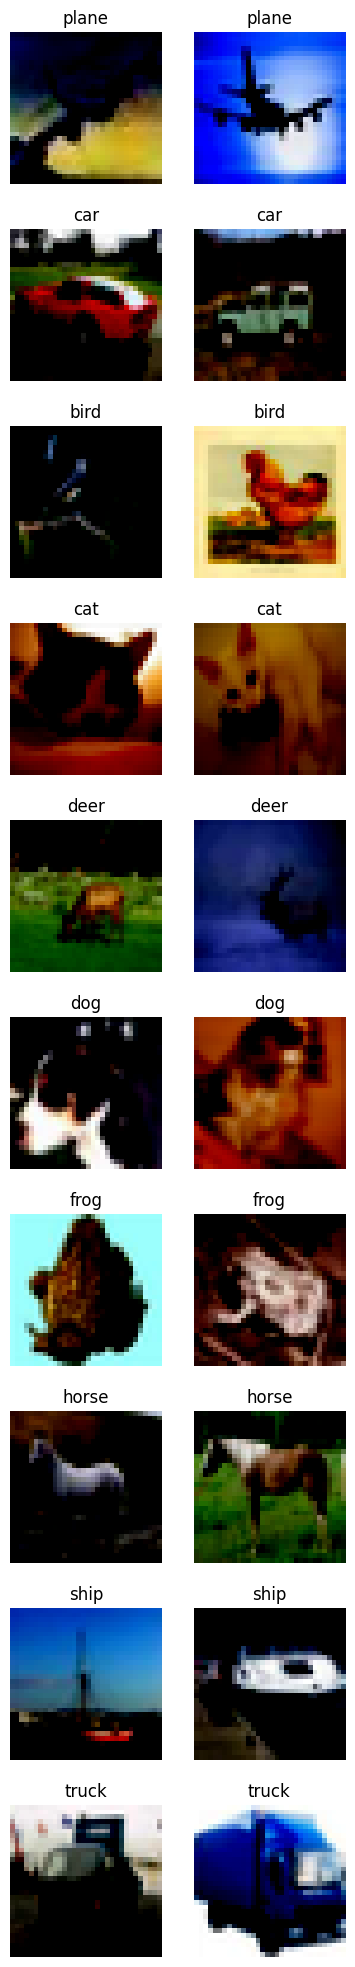

In [39]:
class_images = {classname: [] for classname in classes}
for images, labels in trainloader:
    for image, label in zip(images, labels):
        classname = classes[label]
        if len(class_images[classname]) < 2:
            class_images[classname].append(image)
        if all(len(images) == 2 for images in class_images.values()):
            break
    else:
        continue
    break

# Plotting the images
fig, axs = plt.subplots(10, 2, figsize=(5, 25))  # 10 classes and 2 images each
fig.subplots_adjust(hspace=0.3, wspace=-0.1)
axs = axs.ravel()

for idx, classname in enumerate(classes):
    for j in range(2):
        image = class_images[classname][j]
        axs[2 * idx + j].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axs[2 * idx + j].set_title(f"{classname}")
        axs[2 * idx + j].axis('off')

plt.show()

### Question  Here ***&#8595;***
Implement your model and train it

In [18]:
class CNN(nn.Module):

  """
A  CNN for classification tasks that
inherits from nn.Module, which is a base class for all neural network modules in PyTorch.

Initialize the CNN model by setting up the layers.

Define the forward pass of the CNN.
        Parameters:
        - x (Tensor): The input tensor containing the batch of images. The images
          must be flattened before being passed to the network.

        Returns:
        - x (Tensor): The output tensor containing the logits for each class in the
          batch. To convert these logits to probabilities, apply a softmax function
          outside this method.
  """

  def __init__(self):
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(3, 32, 5, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)

        self.l1 = nn.Linear(128 * 4* 4, 512)
        self.l2 = nn.Linear(512, 10)
        #self.l3 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2, 0)


  def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(self.bn3(x))
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        #x = self.l3(x)
        return x



device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


net = CNN().to(device)



Using cpu device


In [19]:
"""
Add criterion (loss function) and optimizer
"""

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [20]:
num_epochs = 20
train_losses = []

"""
    Epochs: An epoch is a single pass through the entire training dataset.
    The code is set to run for a total of 10 epochs.
    Implement the training loop here

"""

def train(dataloader, net, loss_fn, optimizer):
  size = len(dataloader.dataset)
  net.train()
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = net(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
print("Done!")



Epoch 1
-------------------------------
loss: 2.304996  [   64/10000]
loss: 1.652367  [ 6464/10000]
Epoch 2
-------------------------------
loss: 1.415684  [   64/10000]
loss: 1.157582  [ 6464/10000]
Epoch 3
-------------------------------
loss: 1.599819  [   64/10000]
loss: 1.203705  [ 6464/10000]
Epoch 4
-------------------------------
loss: 1.404057  [   64/10000]
loss: 0.938516  [ 6464/10000]
Epoch 5
-------------------------------
loss: 1.146406  [   64/10000]
loss: 0.729848  [ 6464/10000]
Epoch 6
-------------------------------
loss: 0.889127  [   64/10000]
loss: 0.810729  [ 6464/10000]
Epoch 7
-------------------------------
loss: 0.918244  [   64/10000]
loss: 0.638881  [ 6464/10000]
Epoch 8
-------------------------------
loss: 0.904792  [   64/10000]
loss: 0.357544  [ 6464/10000]
Epoch 9
-------------------------------
loss: 0.585759  [   64/10000]
loss: 0.698465  [ 6464/10000]
Epoch 10
-------------------------------
loss: 0.397115  [   64/10000]
loss: 0.340178  [ 6464/10000]

### Validation Loop
Simple validation loop. Use this to assess your performance

In [7]:
"""
Validation Loop
"""

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 2000 test images: {100 * correct / total}%')

Accuracy of the network on the 2000 test images: 68.05%
